In [1]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# 定义标签和类别字典以及常量 N
label_dict = {"horse": 0, "ship": 1, "truck": 2}
class_dict = {0: "horse", 1: "ship", 2: "truck"}
N = 3  # 总共三个类别

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        # 获取标签文件夹列表
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform
#         self.labels = [label for label in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, label))]
        
#         # 获取图像路径和标签的配对列表
#         self.data = []
#         for label in self.labels:
#             label_path = os.path.join(data_dir, label)
#             for img_fn in os.listdir(label_path):
#                 img_path = os.path.join(label_path, img_fn)
#                 if not os.path.isdir(img_path):
#                     self.data.append((img_path, label_dict[label]))

        # self.transform = transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label
        # img_path, label = self.data[index]
        # img = Image.open(img_path).convert('RGB')
        # if self.transform:
        #     img = self.transform(img)
        # return img, label

    def __len__(self):
        return len(self.data)

def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader

In [3]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

# from classify.data_process import load_data, N, label_dict, class_dict
import torch.nn.functional as F

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)


class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

# 训练模型

In [4]:
train()

data processing...
train...


  3%|##7                                                                                | 1/30 [00:01<00:42,  1.45s/it]

Epoch 000 train_loss 1.09396 val_loss 1.08727


  7%|#####5                                                                             | 2/30 [00:02<00:41,  1.48s/it]

Epoch 001 train_loss 1.05307 val_loss 1.08259


 10%|########3                                                                          | 3/30 [00:04<00:39,  1.48s/it]

Epoch 002 train_loss 1.01145 val_loss 1.06158


 13%|###########                                                                        | 4/30 [00:05<00:38,  1.47s/it]

Epoch 003 train_loss 0.96858 val_loss 1.01852


 17%|#############8                                                                     | 5/30 [00:07<00:36,  1.46s/it]

Epoch 004 train_loss 0.92605 val_loss 0.96698


 20%|################6                                                                  | 6/30 [00:08<00:35,  1.47s/it]

Epoch 005 train_loss 0.90581 val_loss 0.94289


 23%|###################3                                                               | 7/30 [00:10<00:33,  1.47s/it]

Epoch 006 train_loss 0.89011 val_loss 0.94442


 27%|######################1                                                            | 8/30 [00:11<00:32,  1.48s/it]

Epoch 007 train_loss 0.85717 val_loss 0.90097


 30%|########################9                                                          | 9/30 [00:13<00:31,  1.48s/it]

Epoch 008 train_loss 0.84862 val_loss 0.83560


 33%|###########################3                                                      | 10/30 [00:14<00:29,  1.47s/it]

Epoch 009 train_loss 0.82518 val_loss 0.84286


 37%|##############################                                                    | 11/30 [00:16<00:27,  1.46s/it]

Epoch 010 train_loss 0.81560 val_loss 0.84749


 40%|################################8                                                 | 12/30 [00:17<00:26,  1.45s/it]

Epoch 011 train_loss 0.78825 val_loss 0.77784


 43%|###################################5                                              | 13/30 [00:19<00:24,  1.45s/it]

Epoch 012 train_loss 0.77527 val_loss 0.77148


 47%|######################################2                                           | 14/30 [00:20<00:23,  1.44s/it]

Epoch 013 train_loss 0.76654 val_loss 0.79574


 50%|#########################################                                         | 15/30 [00:21<00:21,  1.45s/it]

Epoch 014 train_loss 0.74877 val_loss 0.80287


 53%|###########################################7                                      | 16/30 [00:23<00:20,  1.46s/it]

Epoch 015 train_loss 0.74271 val_loss 0.78395


 57%|##############################################4                                   | 17/30 [00:24<00:19,  1.49s/it]

Epoch 016 train_loss 0.73540 val_loss 0.70725


 60%|#################################################1                                | 18/30 [00:26<00:17,  1.47s/it]

Epoch 017 train_loss 0.72971 val_loss 0.74335


 63%|###################################################9                              | 19/30 [00:27<00:16,  1.47s/it]

Epoch 018 train_loss 0.72707 val_loss 0.76192


 67%|######################################################6                           | 20/30 [00:29<00:14,  1.49s/it]

Epoch 019 train_loss 0.72190 val_loss 0.75744


 70%|#########################################################4                        | 21/30 [00:30<00:13,  1.49s/it]

Epoch 020 train_loss 0.70127 val_loss 0.78170


 73%|############################################################1                     | 22/30 [00:32<00:11,  1.49s/it]

Epoch 021 train_loss 0.69523 val_loss 0.73605


 77%|##############################################################8                   | 23/30 [00:33<00:10,  1.49s/it]

Epoch 022 train_loss 0.68496 val_loss 0.72274


 80%|#################################################################6                | 24/30 [00:35<00:09,  1.50s/it]

Epoch 023 train_loss 0.67922 val_loss 0.74310


 83%|####################################################################3             | 25/30 [00:36<00:07,  1.49s/it]

Epoch 024 train_loss 0.66947 val_loss 0.70737


 87%|#######################################################################           | 26/30 [00:38<00:05,  1.50s/it]

Epoch 025 train_loss 0.66965 val_loss 0.74213


 90%|#########################################################################8        | 27/30 [00:39<00:04,  1.49s/it]

Epoch 026 train_loss 0.66549 val_loss 0.74045


 93%|############################################################################5     | 28/30 [00:41<00:02,  1.49s/it]

Epoch 027 train_loss 0.65702 val_loss 0.70518


 97%|###############################################################################2  | 29/30 [00:42<00:01,  1.49s/it]

Epoch 028 train_loss 0.64844 val_loss 0.69758


100%|##################################################################################| 30/30 [00:44<00:00,  1.48s/it]
2024-11-28 16:55:05.846 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 44.603296756744385 s


Epoch 029 train_loss 0.64894 val_loss 0.74360


# 测试模型预测准确率

In [5]:
test()

data processing...


C:\Users\admin\AppData\Local\Temp/ipykernel_6396/934605258.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)
20

Accuracy:92%


In [6]:
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms

In [7]:
model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/truck/truck-00028.jpg"

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

truck


C:\Users\admin\AppData\Local\Temp/ipykernel_6396/1498475470.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


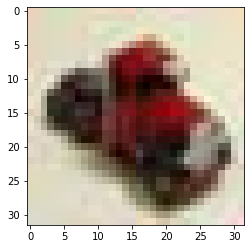

In [8]:
plt.imshow(img, cmap='gray')
plt.show()